# **Klasifikasi Gerakan untuk Rehabilitasi Stroke Menggunakan LSTM**
Dataset yang akan digunakan adalah 10 video gerakan rehabilitasi untuk pasien stroke yang ditemukan di Internet.

Proyek ini bertujuan untuk mendeteksi gerakan ....

# **1. Import Library**

In [ ]:
pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 8.8 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [ ]:
# pip install tensorflow

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import time
import seaborn as sns

from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict, deque
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [19]:
import sys
print(sys.executable)
print(sys.version)


d:\1. Semester 7\LaskarAI\restro\ActionDetection-yolo\ActionDetection-Yolo\.venv\Scripts\python.exe
3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [14]:
!pip install seaborn


In [9]:
!pip install seaborn matplotlib tqdm


# **2. Memuat Dataset**

In [4]:
# Setup Folders for Collection
VIDEO_DIR = '/kaggle/input/dataset/dataset_video' 
sequence_length = 30         # frame per sequence
stride = sequence_length      
augment_mirror    = True     # hanya untuk train video
test_video_idx  = -1         # video ke-berapa per kelas utk hold-out (-1 = terakhir)
RANDOM_SEED     = 42
TRAIN_VIDS, TEST_VIDS = {}, {}

actions = sorted([d for d in os.listdir(VIDEO_DIR)
                  if os.path.isdir(os.path.join(VIDEO_DIR,d))])
print('Kelas terdeteksi:', actions, '\n')

vid_dict = defaultdict(list)   # {action: [video_path, …]}
for act in actions:
    for f in sorted(os.listdir(os.path.join(VIDEO_DIR,act))):
        if f.lower().endswith(('.mp4','.mov','.avi','.mkv')):
            vid_dict[act].append(os.path.join(VIDEO_DIR,act,f))

Kelas terdeteksi: ['Angkat Pinggul', 'Angkat Tangan', 'Lutut Turun', 'Naikan Kepalan Kedepan', 'Rentangkan'] 



# **3. Exploratory Data Analysis (EDA)**

In [5]:
print(os.listdir(VIDEO_DIR))

['Rentangkan', 'Naikan Kepalan Kedepan', 'Lutut Turun', 'Angkat Pinggul', 'Angkat Tangan']


In [6]:
VIDEO_DIR = '/kaggle/input/dataset/dataset_video'
len(os.listdir(VIDEO_DIR))

5

,action,video,fps,frames,duration
0,Angkat Pinggul,1.MOV,59.953704,259,4.320000
1,Angkat Pinggul,10.mp4,30.000000,104,3.466667
2,Angkat Pinggul,2.MOV,59.957326,281,4.686667
3,Angkat Pinggul,3.mp4,24.919779,146,5.858800
4,Angkat Pinggul,4.mp4,24.919583,149,5.979233
5,Angkat Pinggul,5.mp4,24.912027,202,8.108533
6,Angkat Pinggul,6.mp4,24.927840,114,4.573200
7,Angkat Pinggul,7.mp4,30.000000,139,4.633333
8,Angkat Pinggul,8.mp4,30.000000,157,5.233333
9,Angkat Pinggul,9.mp4,30.000000,145,4.833333


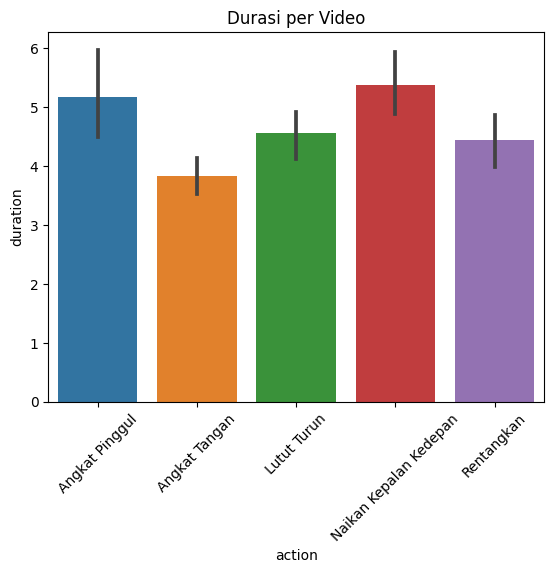

In [7]:
rows=[]
for act in actions:
    for vp in vid_dict[act]:
        cap=cv2.VideoCapture(vp)
        fps  = cap.get(cv2.CAP_PROP_FPS) or 30
        nfrm = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        dur  = nfrm/fps
        rows.append(dict(action=act, video=os.path.basename(vp),
                         fps=fps, frames=nfrm, duration=dur))
        cap.release()
df=pd.DataFrame(rows)
display(df)
sns.barplot(data=df,x='action',y='duration')
plt.xticks(rotation=45); plt.title('Durasi per Video'); plt.show()

# **4. Preprocessing**

In [8]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

# ---------------------------
# Inisialisasi Model YOLOv8
# ---------------------------
model = YOLO("/kaggle/input/yolo8n-pose/pytorch/default/1/yolov8n-pose.pt")  

# ---------------------------
# Pengaturan Folder
# ---------------------------
video_root = "/kaggle/input/dataset/dataset_video"  
keypoint_root = "keypoints"    

# Daftar aksi (label gerakan)
actions = ["Angkat Pinggul", "Angkat Tangan", "Lutut Turun", "Naikan Kepalan Kedepan", "Rentangkan"]

# ---------------------------
# Ekstraksi Keypoint
# ---------------------------
for action in actions:
    video_dir = os.path.join(video_root, action)
    save_dir = os.path.join(keypoint_root, action)
    os.makedirs(save_dir, exist_ok=True)

    for video_name in tqdm(os.listdir(video_dir), desc=f"Proses {action}"):
        video_path = os.path.join(video_dir, video_name)
        cap = cv2.VideoCapture(video_path)
        sequence = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            results = model.predict(source=frame, conf=0.5, save=False, verbose=False)
            keypoints = results[0].keypoints

            if keypoints is not None and len(keypoints.xy) > 0:
                # Ambil keypoint orang pertama
                kps = keypoints.xy[0].cpu().numpy()  # shape: (17, 2)
                if kps.shape[0] == 17:  # pastikan 17 keypoints
                    sequence.append(kps.flatten())  # shape: (34,) = 17 keypoints × 2 (x, y)

        cap.release()

        # Simpan hanya jika ada keypoint valid
        if len(sequence) > 0:
            try:
                sequence = np.array(sequence)  # shape: (n_frames, 34)
                save_path = os.path.join(save_dir, video_name.replace(".MOV", ".npy").replace(".mp4", ".npy"))
                np.save(save_path, sequence)
                print(f"✅ Keypoint disimpan: {save_path}")
            except ValueError as e:
                print(f"❌ Gagal menyimpan {video_name}: {e}")
        else:
            print(f"⚠️ Tidak ada keypoint di {video_name}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Proses Angkat Pinggul:  10%|█         | 1/10 [00:33<04:58, 33.19s/it]

✅ Keypoint disimpan: keypoints/Angkat Pinggul/5.npy


Proses Angkat Pinggul:  20%|██        | 2/10 [01:11<04:50, 36.37s/it]

✅ Keypoint disimpan: keypoints/Angkat Pinggul/1.npy


Proses Angkat Pinggul:  30%|███       | 3/10 [01:31<03:21, 28.80s/it]

✅ Keypoint disimpan: keypoints/Angkat Pinggul/3.npy


Proses Angkat Pinggul:  40%|████      | 4/10 [01:54<02:38, 26.34s/it]

✅ Keypoint disimpan: keypoints/Angkat Pinggul/8.npy


Proses Angkat Pinggul:  50%|█████     | 5/10 [02:34<02:36, 31.23s/it]

✅ Keypoint disimpan: keypoints/Angkat Pinggul/2.npy


Proses Angkat Pinggul:  60%|██████    | 6/10 [02:57<01:53, 28.43s/it]

✅ Keypoint disimpan: keypoints/Angkat Pinggul/9.npy


Proses Angkat Pinggul:  70%|███████   | 7/10 [03:12<01:12, 24.33s/it]

✅ Keypoint disimpan: keypoints/Angkat Pinggul/6.npy


Proses Angkat Pinggul:  80%|████████  | 8/10 [03:43<00:52, 26.30s/it]

✅ Keypoint disimpan: keypoints/Angkat Pinggul/4.npy


Proses Angkat Pinggul:  90%|█████████ | 9/10 [03:58<00:22, 22.92s/it]

✅ Keypoint disimpan: keypoints/Angkat Pinggul/10.npy


Proses Angkat Pinggul: 100%|██████████| 10/10 [04:19<00:00, 25.93s/it]


✅ Keypoint disimpan: keypoints/Angkat Pinggul/7.npy


Proses Angkat Tangan:  10%|█         | 1/10 [00:14<02:12, 14.69s/it]

✅ Keypoint disimpan: keypoints/Angkat Tangan/5.npy


Proses Angkat Tangan:  20%|██        | 2/10 [00:32<02:12, 16.58s/it]

✅ Keypoint disimpan: keypoints/Angkat Tangan/3.npy


Proses Angkat Tangan:  30%|███       | 3/10 [00:46<01:46, 15.19s/it]

✅ Keypoint disimpan: keypoints/Angkat Tangan/8.npy


Proses Angkat Tangan:  40%|████      | 4/10 [01:00<01:28, 14.71s/it]

✅ Keypoint disimpan: keypoints/Angkat Tangan/9.npy


Proses Angkat Tangan:  50%|█████     | 5/10 [01:14<01:13, 14.67s/it]

✅ Keypoint disimpan: keypoints/Angkat Tangan/1.npy


Proses Angkat Tangan:  60%|██████    | 6/10 [01:31<01:01, 15.37s/it]

✅ Keypoint disimpan: keypoints/Angkat Tangan/6.npy


Proses Angkat Tangan:  70%|███████   | 7/10 [01:42<00:42, 14.03s/it]

✅ Keypoint disimpan: keypoints/Angkat Tangan/4.npy


Proses Angkat Tangan:  80%|████████  | 8/10 [01:55<00:27, 13.78s/it]

✅ Keypoint disimpan: keypoints/Angkat Tangan/10.npy


Proses Angkat Tangan:  90%|█████████ | 9/10 [02:10<00:14, 14.06s/it]

✅ Keypoint disimpan: keypoints/Angkat Tangan/7.npy


Proses Angkat Tangan: 100%|██████████| 10/10 [02:22<00:00, 14.20s/it]


✅ Keypoint disimpan: keypoints/Angkat Tangan/2.npy


Proses Lutut Turun:  10%|█         | 1/10 [00:15<02:22, 15.88s/it]

✅ Keypoint disimpan: keypoints/Lutut Turun/5.npy


Proses Lutut Turun:  20%|██        | 2/10 [00:51<03:41, 27.71s/it]

✅ Keypoint disimpan: keypoints/Lutut Turun/1.npy


Proses Lutut Turun:  30%|███       | 3/10 [01:07<02:36, 22.39s/it]

✅ Keypoint disimpan: keypoints/Lutut Turun/3.npy


Proses Lutut Turun:  40%|████      | 4/10 [01:26<02:05, 20.93s/it]

✅ Keypoint disimpan: keypoints/Lutut Turun/8.npy


Proses Lutut Turun:  50%|█████     | 5/10 [02:01<02:09, 25.90s/it]

✅ Keypoint disimpan: keypoints/Lutut Turun/2.npy


Proses Lutut Turun:  60%|██████    | 6/10 [02:17<01:30, 22.52s/it]

✅ Keypoint disimpan: keypoints/Lutut Turun/9.npy


Proses Lutut Turun:  70%|███████   | 7/10 [02:33<01:01, 20.51s/it]

✅ Keypoint disimpan: keypoints/Lutut Turun/6.npy


Proses Lutut Turun:  80%|████████  | 8/10 [02:48<00:37, 18.69s/it]

✅ Keypoint disimpan: keypoints/Lutut Turun/4.npy


Proses Lutut Turun:  90%|█████████ | 9/10 [03:00<00:16, 16.52s/it]

✅ Keypoint disimpan: keypoints/Lutut Turun/10.npy


Proses Lutut Turun: 100%|██████████| 10/10 [03:18<00:00, 19.88s/it]


✅ Keypoint disimpan: keypoints/Lutut Turun/7.npy


Proses Naikan Kepalan Kedepan:  10%|█         | 1/10 [00:15<02:16, 15.12s/it]

✅ Keypoint disimpan: keypoints/Naikan Kepalan Kedepan/3.npy


Proses Naikan Kepalan Kedepan:  20%|██        | 2/10 [00:32<02:10, 16.36s/it]

✅ Keypoint disimpan: keypoints/Naikan Kepalan Kedepan/8.npy


Proses Naikan Kepalan Kedepan:  30%|███       | 3/10 [01:08<02:56, 25.18s/it]

✅ Keypoint disimpan: keypoints/Naikan Kepalan Kedepan/6.npy


Proses Naikan Kepalan Kedepan:  40%|████      | 4/10 [01:28<02:20, 23.50s/it]

✅ Keypoint disimpan: keypoints/Naikan Kepalan Kedepan/9.npy


Proses Naikan Kepalan Kedepan:  50%|█████     | 5/10 [01:42<01:40, 20.00s/it]

✅ Keypoint disimpan: keypoints/Naikan Kepalan Kedepan/1.npy


Proses Naikan Kepalan Kedepan:  60%|██████    | 6/10 [02:02<01:19, 19.93s/it]

✅ Keypoint disimpan: keypoints/Naikan Kepalan Kedepan/4.npy


Proses Naikan Kepalan Kedepan:  70%|███████   | 7/10 [02:22<00:59, 19.84s/it]

✅ Keypoint disimpan: keypoints/Naikan Kepalan Kedepan/10.npy


Proses Naikan Kepalan Kedepan:  80%|████████  | 8/10 [02:48<00:43, 21.81s/it]

✅ Keypoint disimpan: keypoints/Naikan Kepalan Kedepan/7.npy


Proses Naikan Kepalan Kedepan:  90%|█████████ | 9/10 [03:22<00:25, 25.65s/it]

✅ Keypoint disimpan: keypoints/Naikan Kepalan Kedepan/5.npy


Proses Naikan Kepalan Kedepan: 100%|██████████| 10/10 [03:40<00:00, 22.06s/it]


✅ Keypoint disimpan: keypoints/Naikan Kepalan Kedepan/2.npy


Proses Rentangkan:  10%|█         | 1/10 [00:10<01:37, 10.78s/it]

✅ Keypoint disimpan: keypoints/Rentangkan/3.npy


Proses Rentangkan:  20%|██        | 2/10 [00:30<02:06, 15.84s/it]

✅ Keypoint disimpan: keypoints/Rentangkan/8.npy


Proses Rentangkan:  30%|███       | 3/10 [00:55<02:21, 20.17s/it]

✅ Keypoint disimpan: keypoints/Rentangkan/6.npy


Proses Rentangkan:  40%|████      | 4/10 [01:08<01:43, 17.33s/it]

✅ Keypoint disimpan: keypoints/Rentangkan/9.npy


Proses Rentangkan:  50%|█████     | 5/10 [01:20<01:16, 15.38s/it]

✅ Keypoint disimpan: keypoints/Rentangkan/1.npy


Proses Rentangkan:  60%|██████    | 6/10 [01:36<01:02, 15.52s/it]

✅ Keypoint disimpan: keypoints/Rentangkan/4.npy


Proses Rentangkan:  70%|███████   | 7/10 [01:54<00:48, 16.29s/it]

✅ Keypoint disimpan: keypoints/Rentangkan/10.npy


Proses Rentangkan:  80%|████████  | 8/10 [02:13<00:34, 17.37s/it]

✅ Keypoint disimpan: keypoints/Rentangkan/7.npy


Proses Rentangkan:  90%|█████████ | 9/10 [02:36<00:19, 19.05s/it]

✅ Keypoint disimpan: keypoints/Rentangkan/5.npy


Proses Rentangkan: 100%|██████████| 10/10 [02:50<00:00, 17.10s/it]

✅ Keypoint disimpan: keypoints/Rentangkan/2.npy


In [9]:
import cv2
from ultralytics import YOLO

model = YOLO("yolov8n-pose.pt")

video_path = "/kaggle/input/dataset/dataset_video/Rentangkan/5.MOV"
cap = cv2.VideoCapture(video_path)

# Dapatkan ukuran frame
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Inisialisasi writer untuk menyimpan video hasil
out = cv2.VideoWriter('output_pose.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(source=frame, save=False, conf=0.3)
    annotated_frame = results[0].plot()
    out.write(annotated_frame)

cap.release()
out.release()
print("✅ Hasil berhasil disimpan ke output_pose.mp4")


100%|██████████| 6.52M/6.52M [00:00<00:00, 185MB/s]



0: 384x640 2 persons, 130.6ms
Speed: 3.0ms preprocess, 130.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 118.3ms
Speed: 4.3ms preprocess, 118.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 124.5ms
Speed: 4.5ms preprocess, 124.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 123.2ms
Speed: 3.3ms preprocess, 123.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 120.8ms
Speed: 5.3ms preprocess, 120.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 121.5ms
Speed: 3.0ms preprocess, 121.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 113.7ms
Speed: 3.9ms preprocess, 113.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 116.6ms
Speed: 3.0ms preprocess, 116.6ms inference, 1.5ms postprocess per i

### Persiapan Dataset untuk Training


In [10]:
import os
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

# Misal direktori keypoints per aksi sudah ada
keypoint_root = "keypoints"
actions = ["Angkat Pinggul", "Angkat Tangan", "Lutut Turun", "Naikan Kepalan Kedepan", "Rentangkan"]

X, y, groups = [], [], []

# Loop untuk load semua data .npy
for idx, action in enumerate(actions):
    action_dir = os.path.join(keypoint_root, action)
    for file in os.listdir(action_dir):
        if file.endswith('.npy'):
            filepath = os.path.join(action_dir, file)
            seq = np.load(filepath)  # bentuk: (n_frames, n_features)
            
            # Bisa lakukan padding/truncation di sini supaya shape uniform
            # contoh: ambil 30 frames saja (atau padding jika kurang)
            desired_frames = 30
            if seq.shape[0] > desired_frames:
                seq = seq[:desired_frames, :]
            elif seq.shape[0] < desired_frames:
                pad_width = desired_frames - seq.shape[0]
                seq = np.pad(seq, ((0,pad_width),(0,0)), mode='constant')

            X.append(seq)
            y.append(idx)  # label encoded numerik
            groups.append(file.split('_')[0])  # misal grup berdasarkan nama file, bisa diubah sesuai kebutuhan

X = np.array(X)  # shape (N_samples, timesteps, features)
y = np.array(y)
groups = np.array(groups)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)
print("Groups shape:", groups.shape)

Data shape: (50, 30, 34)
Labels shape: (50,)
Groups shape: (50,)


### Split Data

In [11]:
# Fungsi augmentasi: tambahkan noise Gaussian pada keypoint
def augment_data(X, noise_level=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
    X_aug = X + noise
    return X_aug


In [12]:
from sklearn.model_selection import GroupShuffleSplit

RANDOM_SEED = 42
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

train_idx, val_idx = next(gss.split(X, y, groups))

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

# Augmentasi hanya di data train
X_train_aug = augment_data(X_train, noise_level=0.01)


Train shape: (40, 30, 34)
Validation shape: (10, 30, 34)


### One-hot encode label

In [13]:
import sys
print(sys.version)


3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [14]:
from tensorflow.keras.utils import to_categorical

num_classes = len(actions)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# Cek dimensi input dan output
print("X_train shape:", X_train_aug.shape)     # contoh: (jumlah_sample, 30, 34)
print("y_train shape:", y_train.shape)     # contoh: (jumlah_sample, num_classes)



X_train shape: (40, 30, 34)
y_train shape: (40, 5)


# **5. Pembangunan Model**

## **a. Pelatihan Model**

In [15]:
print("Shape y_train:", y_train.shape)
print("Shape y_val:", y_val.shape)
print("Jumlah kelas:", len(actions))


Shape y_train: (40, 5)
Shape y_val: (10, 5)
Jumlah kelas: 5


In [16]:
# Ambil nilai dari shape input untuk digunakan di model
sequence_length = X_train_aug.shape[1]         # contoh: 30
num_features = X_train_aug.shape[2]            # contoh: 34

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ambil nilai shape input dari X_train

model_lstm = Sequential([
    LSTM(32, return_sequences=False, input_shape=(X_train_aug.shape[1], X_train_aug.shape[2])),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    
    Dense(len(actions), activation='softmax')
])


model_lstm.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

callbacks_lstm = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint('lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

history_lstm = model_lstm.fit(
    X_train_aug, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=4,          # Lebih kecil agar bisa belajar stabil
    shuffle=True,
    callbacks=callbacks_lstm,
    verbose=2
)




2025-05-26 04:15:07.400048: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200

Epoch 1: val_loss improved from inf to 1.67103, saving model to lstm_best.keras
10/10 - 4s - 416ms/step - categorical_accuracy: 0.1750 - loss: 1.5924 - val_categorical_accuracy: 0.2000 - val_loss: 1.6710
Epoch 2/200

Epoch 2: val_loss did not improve from 1.67103
10/10 - 0s - 19ms/step - categorical_accuracy: 0.1000 - loss: 1.7665 - val_categorical_accuracy: 0.2000 - val_loss: 1.6716
Epoch 3/200

Epoch 3: val_loss improved from 1.67103 to 1.65589, saving model to lstm_best.keras
10/10 - 0s - 23ms/step - categorical_accuracy: 0.2500 - loss: 1.6756 - val_categorical_accuracy: 0.2000 - val_loss: 1.6559
Epoch 4/200

Epoch 4: val_loss improved from 1.65589 to 1.65166, saving model to lstm_best.keras
10/10 - 0s - 23ms/step - categorical_accuracy: 0.2500 - loss: 1.6224 - val_categorical_accuracy: 0.2000 - val_loss: 1.6517
Epoch 5/200

Epoch 5: val_loss improved from 1.65166 to 1.64664, saving model to lstm_best.keras
10/10 - 0s - 22ms/step - categorical_accuracy: 0.1500 - loss: 1

## GRU

In [18]:
# Ambil dimensi input dari X_train
sequence_length = X_train.shape[1]  # jumlah langkah waktu (timesteps)
feature_size = X_train.shape[2]     # jumlah fitur per timestep

# Model GRU
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(sequence_length, feature_size)),
    BatchNormalization(),
    Dropout(0.4),

    GRU(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.4),

    GRU(64),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(actions), activation='softmax')  # Pastikan 'actions' adalah daftar label unik
])

# Kompilasi model
model_gru.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

# Callback
callbacks_gru = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('gru_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

# Training model
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks_gru,
    verbose=2
)

Epoch 1/150

Epoch 1: val_loss improved from inf to 1.64559, saving model to gru_best.keras
2/2 - 15s - 7s/step - categorical_accuracy: 0.2500 - loss: 2.8436 - val_categorical_accuracy: 0.1000 - val_loss: 1.6456 - learning_rate: 1.0000e-04
Epoch 2/150

Epoch 2: val_loss improved from 1.64559 to 1.62968, saving model to gru_best.keras
2/2 - 0s - 186ms/step - categorical_accuracy: 0.2500 - loss: 2.6532 - val_categorical_accuracy: 0.1000 - val_loss: 1.6297 - learning_rate: 1.0000e-04
Epoch 3/150

Epoch 3: val_loss improved from 1.62968 to 1.61918, saving model to gru_best.keras
2/2 - 0s - 156ms/step - categorical_accuracy: 0.3500 - loss: 2.0200 - val_categorical_accuracy: 0.1000 - val_loss: 1.6192 - learning_rate: 1.0000e-04
Epoch 4/150

Epoch 4: val_loss improved from 1.61918 to 1.61143, saving model to gru_best.keras
2/2 - 0s - 168ms/step - categorical_accuracy: 0.2750 - loss: 2.3324 - val_categorical_accuracy: 0.1000 - val_loss: 1.6114 - learning_rate: 1.0000e-04
Epoch 5/150

Epoch 5: 

In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

# Misal X_train, X_val, y_train, y_val sudah ada

# Contoh: ambil shape dari X_train
sequence_length = X_train.shape[1]  # 30
feature_size = X_train.shape[2]     # 34

# Normalisasi fitur secara per fitur (feature-wise) untuk setiap timestep
scaler = StandardScaler()

# Flatten data agar bisa di-scaler, lalu reshape kembali
X_train_flat = X_train.reshape(-1, feature_size)
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(-1, sequence_length, feature_size)

X_val_flat = X_val.reshape(-1, feature_size)
X_val_scaled = scaler.transform(X_val_flat).reshape(-1, sequence_length, feature_size)

# Pastikan actions adalah list label yang sesuai dengan jumlah kelas
num_classes = len(actions)  # misal actions = ['walking', 'running', 'jumping', ...]

# Definisi model 1D CNN
model_cnn = Sequential([
    Conv1D(256, kernel_size=9, dilation_rate=2, activation='relu', input_shape=(sequence_length, feature_size), padding='same'),
    BatchNormalization(), 
    Dropout(0.4),

    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(), 
    Dropout(0.4),

    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    BatchNormalization(), 
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
model_cnn.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

# Callbacks untuk early stopping, checkpoint, dan learning rate scheduler
callbacks_cnn = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss', verbose=1),
    ModelCheckpoint('cnn_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

# Training model
history_cnn = model_cnn.fit(
    X_train_scaled, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks_cnn,
    verbose=2
)


Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_loss improved from inf to 1.53930, saving model to cnn_best.keras
2/2 - 6s - 3s/step - categorical_accuracy: 0.1250 - loss: 2.9595 - val_categorical_accuracy: 0.1000 - val_loss: 1.5393 - learning_rate: 1.0000e-04
Epoch 2/150

Epoch 2: val_loss improved from 1.53930 to 1.47126, saving model to cnn_best.keras
2/2 - 0s - 126ms/step - categorical_accuracy: 0.4250 - loss: 1.8721 - val_categorical_accuracy: 0.4000 - val_loss: 1.4713 - learning_rate: 1.0000e-04
Epoch 3/150

Epoch 3: val_loss improved from 1.47126 to 1.40649, saving model to cnn_best.keras
2/2 - 0s - 123ms/step - categorical_accuracy: 0.4500 - loss: 1.5387 - val_categorical_accuracy: 0.5000 - val_loss: 1.4065 - learning_rate: 1.0000e-04
Epoch 4/150

Epoch 4: val_loss improved from 1.40649 to 1.34857, saving model to cnn_best.keras
2/2 - 0s - 136ms/step - categorical_accuracy: 0.4750 - loss: 1.2385 - val_categorical_accuracy: 0.7000 - val_loss: 1.3486 - learning_rate: 1.0000e-04
Epoch 5/150

Epoch 5: val_loss impr

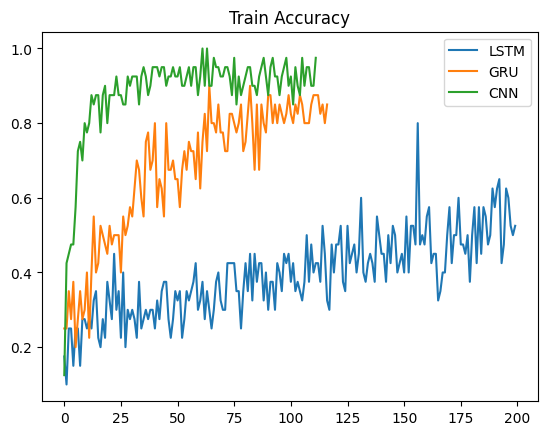

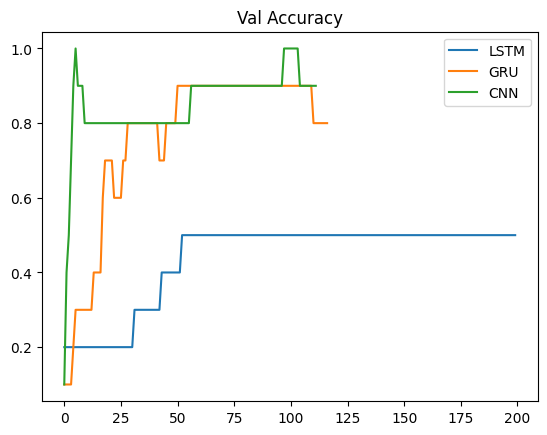

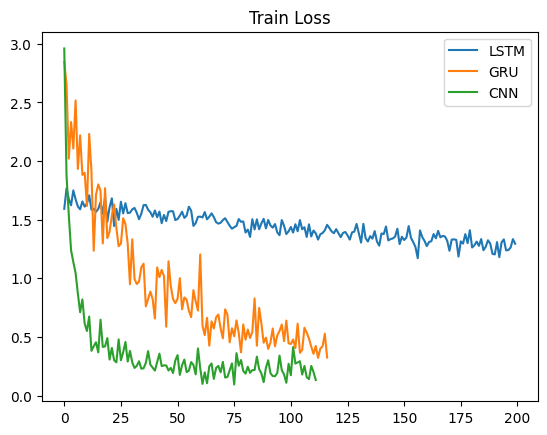

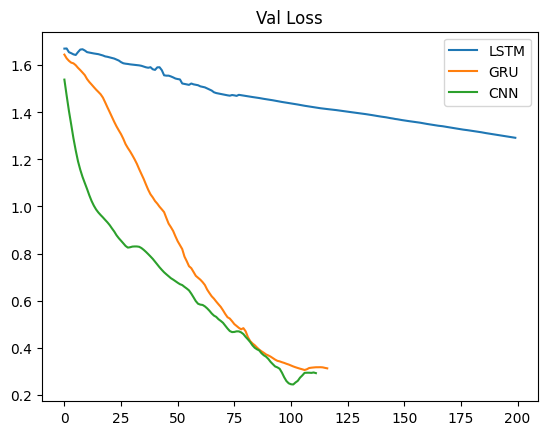

In [20]:
plt.figure()
plt.plot(history_lstm.history['categorical_accuracy'], label='LSTM')
plt.plot(history_gru.history['categorical_accuracy'], label='GRU')
plt.plot(history_cnn.history['categorical_accuracy'], label='CNN')
plt.legend() 
plt.title("Train Accuracy")

plt.figure()
plt.plot(history_lstm.history['val_categorical_accuracy'], label='LSTM')
plt.plot(history_gru.history['val_categorical_accuracy'], label='GRU')
plt.plot(history_cnn.history['val_categorical_accuracy'], label='CNN')
plt.legend()
plt.title("Val Accuracy")

plt.figure()
plt.plot(history_lstm.history['loss'], label='LSTM')
plt.plot(history_gru.history['loss'], label='GRU')
plt.plot(history_cnn.history['loss'], label='CNN')
plt.legend()
plt.title("Train Loss")
plt.show()

plt.figure()
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.plot(history_gru.history['val_loss'], label='GRU')
plt.plot(history_cnn.history['val_loss'], label='CNN')
plt.legend()
plt.title("Val Loss")
plt.show()

## **b. Evaluasi Model**


=== Validation Performance ===


,acc,prec,rec,f1
model,,,,
LSTM,0.5,0.400,0.5,0.393
GRU,0.9,0.933,0.9,0.893
CNN,0.6,0.400,0.6,0.467


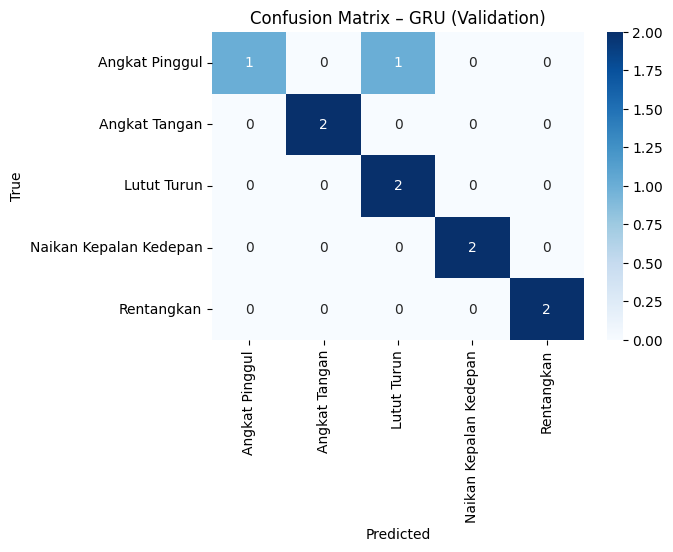

                        precision    recall  f1-score   support

        Angkat Pinggul       1.00      0.50      0.67         2
         Angkat Tangan       1.00      1.00      1.00         2
           Lutut Turun       0.67      1.00      0.80         2
Naikan Kepalan Kedepan       1.00      1.00      1.00         2
            Rentangkan       1.00      1.00      1.00         2

              accuracy                           0.90        10
             macro avg       0.93      0.90      0.89        10
          weighted avg       0.93      0.90      0.89        10



In [21]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import load_model
# =========================
# 2. Fungsi Evaluasi di Validation Set
# =========================
def eval_val(model):
    y_prob = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_val, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    return acc, prec, rec, f1, y_true, y_pred

# =========================
# 3. Evaluasi Semua Model
# =========================
models = {
    'LSTM': 'lstm_best.keras',
    'GRU': 'gru_best.keras',
    'CNN': 'cnn_best.keras'
}

scores = []

for name, fpath in models.items():
    m = load_model(fpath)
    acc, prec, rec, f1, _, _ = eval_val(m)
    scores.append(dict(model=name, acc=acc, prec=prec, rec=rec, f1=f1))

print('\n=== Validation Performance ===')
perf = pd.DataFrame(scores).set_index('model').round(3)
display(perf)

# =========================
# 4. Model Terbaik + Confusion Matrix
# =========================
best = perf['f1'].idxmax()
best_model = load_model(models[best])
acc, prec, rec, f1, y_true, y_pred = eval_val(best_model)

cm = confusion_matrix(y_true, y_pred, labels=range(len(actions)))
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=actions, yticklabels=actions, cmap='Blues')
plt.title(f'Confusion Matrix – {best} (Validation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred, target_names=actions, zero_division=0))

In [26]:
import shutil

# Kompres folder 'keypoint' jadi 'keypoint.zip' di direktori kerja
shutil.make_archive('/kaggle/working/keypoints', 'zip', '/kaggle/working/keypoints')


'/kaggle/working/keypoints.zip'

# **6. Inferensi Model**

## **a. Inferensi Klasifikasi Gerakan**

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from collections import deque

# ------------ Parameter ---------------
SEQ_LEN       = 30
DETECT_THRESH = 0.6
LABELS = np.array(['Angkat Pinggul', 'Kaki Kebelakang', 'Lutut Turun', 'Naikan Kepalan Kedepan', 'Rentangkan'])

# ------------ Load model ---------------
pose_model = YOLO('yolov8n-pose.pt')         # YOLOv8 pose model
lstm_model = load_model('gru_best.keras')  # Model LSTM hasil training

# ------------ Buffer sequence -----------
buf = deque(maxlen=SEQ_LEN)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Inference YOLOv8 Pose
    results = pose_model(frame)[0]

    # Ekstrak keypoints orang pertama jika ada
    if results.keypoints is not None and len(results.keypoints) > 0:
        # Ambil data keypoints dari atribut data dan ubah ke numpy array
        keypoints = results.keypoints.data.cpu().numpy()[0]  # (17, 3)

        h, w, _ = frame.shape
        pose_vec = []
        for x, y, c in keypoints:
            pose_vec.extend([x / w, y / h, c])
        pose_vec = np.array(pose_vec, dtype='float32')
    else:
        pose_vec = np.zeros(17 * 3, dtype='float32')  # kalau gak ada pose

    buf.append(pose_vec)

    # Jika buffer sequence sudah penuh, infer LSTM
    if len(buf) == SEQ_LEN:
        seq_input = np.expand_dims(np.array(buf), axis=0)  # (1, SEQ_LEN, 51)
        probs = lstm_model.predict(seq_input, verbose=0)[0]  # output probabilitas per kelas
        idx_pred = np.argmax(probs)
        conf = probs[idx_pred]
        pred_label = LABELS[idx_pred]

        # Tampilkan prediksi di frame
        text = f"Pose: {pred_label} ({conf*100:.1f}%)"
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0) if conf > DETECT_THRESH else (0, 0, 255), 2)

    # Tampilkan hasil keypoints
    annotated_frame = results.plot()
    cv2.imshow('YOLOv8 Pose + LSTM', annotated_frame)

    if cv2.waitKey(1) & 0xFF == 27:  # ESC keluar
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 1 person, 261.0ms
Speed: 4.8ms preprocess, 261.0ms inference, 29.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 295.9ms
Speed: 5.3ms preprocess, 295.9ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 259.8ms
Speed: 7.8ms preprocess, 259.8ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 166.5ms
Speed: 4.9ms preprocess, 166.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 182.6ms
Speed: 4.5ms preprocess, 182.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 156.1ms
Speed: 3.1ms preprocess, 156.1ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 180.3ms
Speed: 3.3ms preprocess, 180.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 182.0ms
Speed: 3.4ms preprocess, 182.0ms inference, 3.1ms postprocess per image a

ValueError: Exception encountered when calling GRUCell.call().

[1mDimensions must be equal, but are 51 and 34 for '{{node sequential_1_1/gru_1/gru_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1_1/gru_1/strided_slice_1, sequential_1_1/gru_1/gru_cell_1/Cast/ReadVariableOp)' with input shapes: [1,51], [34,384].[0m

Arguments received by GRUCell.call():
  • inputs=tf.Tensor(shape=(1, 51), dtype=float32)
  • states=('tf.Tensor(shape=(1, 128), dtype=float32)',)
  • training=False

: 

## **b. Inferensi Lanjutan**

In [ ]:
import cv2
import numpy as np
import time
from collections import deque
from ultralytics import YOLO
from tensorflow.keras.models import load_model

# ---------- LABEL TETAP (sesuai training) ----------
LABELS = np.array(['Angkat Pinggul',
                   'Kaki Kebelakang',
                   'Lutut Turun',
                   'Naikan Kepalan Kedepan',
                   'Rentangkan'])

label2idx = {l: i for i, l in enumerate(LABELS)}

# ---------- URUTAN LATIHAN (bebas diubah) ----------
WORKFLOW = np.array(['Naikan Kepalan Kedepan',
                     'Rentangkan',
                     'Lutut Turun',
                     'Kaki Kebelakang',
                     'Angkat Pinggul'])

# ---------- PARAMETER LAIN ----------
SEQ_LEN = 30
DETECT_THRESH = 0.60
STABLE_FRAMES = 15
EXER_TIME = 30
POPUP_TIME = 10
MODEL_PATH = 'lstm_best.keras'
FONT = cv2.FONT_HERSHEY_SIMPLEX

# ---------- MODEL & YOLO ----------
model = load_model(MODEL_PATH)
yolo_model = YOLO('yolov8n-pose.pt')  # Gunakan model YOLOv8 Pose

# ---------- Fungsi Ekstraksi Keypoints ----------
def extract_keypoints(results):
    keypoints = results.keypoints
    if keypoints is not None:
        # Ambil keypoints dalam format [x, y, confidence]
        kpts = keypoints.xy[0].cpu().numpy().flatten()
    else:
        kpts = np.zeros(17 * 3)  # 17 keypoints dengan [x, y, conf]
    return kpts.astype('float32')

# ------- Inisialisasi sebelum while ----------
buf = deque(maxlen=SEQ_LEN)
state = 'Belum Bergerak'
idx_act = 0
steady_ctr = 0
t_ex_start = time.time()

popup_phase = None  # None | 'result' | 'prep'
popup_start = None
score = {w: None for w in WORKFLOW}
last_pred, last_conf = '-', 0.0

cap = cv2.VideoCapture(0)
while cap.isOpened() and idx_act < len(WORKFLOW):
    ok, frame = cap.read()
    if not ok:
        break

    # ------------ YOLO Pose Estimation -------------
    results = yolo_model.predict(frame, verbose=False)
    bgr = frame.copy()

    # ------------ Gambar Keypoints -------------
    if results and results[0].keypoints is not None:
        for kp in results[0].keypoints.xy:
            for x, y in kp.cpu().numpy():
                cv2.circle(bgr, (int(x), int(y)), 3, (0, 255, 0), -1)

    # =====================================================
    # ===============  (1)  INFERENCE  ====================
    # =====================================================
    keypoints = extract_keypoints(results[0])
    buf.append(keypoints)
    if len(buf) == SEQ_LEN and popup_phase is None:  # jangan infer saat popup
        prob = model.predict(np.expand_dims(buf, 0), verbose=0)[0]
        idx_pred = int(np.argmax(prob))
        last_pred = LABELS[idx_pred]
        last_conf = float(prob[idx_pred])

        target_lbl = WORKFLOW[idx_act]
        same_act = (last_pred == target_lbl) and (last_conf >= DETECT_THRESH)
        steady_ctr = steady_ctr + 1 if same_act else 0

        if state == 'Belum Bergerak' and steady_ctr >= STABLE_FRAMES:
            state = 'Sudah Setengah Gerakan'
            t_half = time.time()

        elif state == 'Sudah Setengah Gerakan':
            if steady_ctr >= STABLE_FRAMES and time.time() - t_half > 1.0:
                state = 'Gerakan Berhasil'
                score[target_lbl] = True
                popup_phase = 'result'  # ← tampilkan hasil, tunggu ENTER

        if last_conf < 0.20:
            state = 'Belum Bergerak'
            steady_ctr = 0

    # =====================================================
    # ===============  (2)  TIMER  ========================
    # =====================================================
    remaining = EXER_TIME - int(time.time() - t_ex_start)
    if popup_phase is None and remaining <= 0:
        state = 'Gerakan Gagal'
        score[WORKFLOW[idx_act]] = False
        popup_phase = 'result'

    # =====================================================
    # ===============  (3)  POP-UP  =======================
    # =====================================================
    if popup_phase is not None:
        remaining = max(0, remaining)  # ← mencegah nilai negatif

        key = cv2.waitKey(10) & 0xFF
        if popup_phase == 'result':
            # ---------- layar hasil ----------
            cv2.rectangle(bgr, (40, 140), (600, 270), (0, 0, 0), -1)
            cv2.putText(bgr,
                        f'Gerakan {WORKFLOW[idx_act]} : '
                        + ('BERHASIL' if score[WORKFLOW[idx_act]] else 'GAGAL'),
                        (60, 190), FONT, 0.8, (255, 255, 255), 2)

            if idx_act + 1 < len(WORKFLOW):
                cv2.putText(bgr, 'Tekan ENTER untuk lanjut',
                            (60, 230), FONT, 0.7, (0, 255, 255), 2)
            else:
                cv2.putText(bgr, 'Sesi selesai, tekan ESC untuk keluar',
                            (60, 230), FONT, 0.7, (0, 255, 255), 2)

            # -------- tunggu ENTER ----------
            if key in (13, 10):  # ENTER key
                popup_phase = 'prep'
                popup_start = time.time()

        elif popup_phase == 'prep':
            # ---------- hitung mundur ----------
            elap = time.time() - popup_start
            cnt = POPUP_TIME - int(elap)

            cv2.rectangle(bgr, (40, 140), (600, 270), (0, 0, 0), -1)
            cv2.putText(bgr, f'Siapkan gerakan : {WORKFLOW[idx_act+1]}',
                        (60, 190), FONT, 0.7, (255, 255, 255), 2)
            cv2.putText(bgr, f'Mulai dalam {cnt:02d} dtk',
                        (60, 230), FONT, 0.9, (0, 255, 255), 2)

            if elap >= POPUP_TIME:
                # reset ke gerakan berikutnya
                idx_act += 1
                if idx_act == len(WORKFLOW):
                    break
                state = 'Belum Bergerak'
                steady_ctr = 0
                buf.clear()
                t_ex_start = time.time()
                popup_phase = None

        cv2.imshow('Rehab-Assist', bgr)
        if key == 27:  # ESC
            break
        continue

    # =====================================================
    # ===============  (4)  HUD  ==========================
    # =====================================================
    cv2.rectangle(bgr, (0, 0), (640, 60), (0, 0, 0), -1)
    cv2.putText(bgr,
                f'Aksi: {WORKFLOW[idx_act]}   |   Timer: {remaining:02d}s',
                (10, 25), FONT, 0.6, (255, 255, 255), 2)

    det_txt = f"{last_pred if last_pred != '-' else '-'} ({last_conf*100:4.0f}%)"
    cv2.putText(bgr,
                f'Deteksi: {det_txt}',
                (10, 50), FONT, 0.6, (0, 255, 255), 2)

    cv2.rectangle(bgr, (0, 440), (640, 480), (0, 0, 0), -1)
    cv2.putText(bgr, f'Status: {state}', (10, 470), FONT, 0.7, (0, 255, 255), 2)

    key = cv2.waitKey(10) & 0xFF
    if key == 27:  # ESC
        break

    cv2.imshow('Rehab-Assist', bgr)

cap.release()
cv2.destroyAllWindows()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.

: 

In [ ]:
pip freeze requirements.txt